# 1. Genotypes predictions

We can predict the hypocotyl elongation upon both growth differentia conditions framework of Cañibaño et. al 2025 and Nieto et. al 2022.

The model selected is the one using PIF and COP1 productory effect in ABA factor with Hill coeffients $n=8$.

## 1.1. Model Definition

### Importing modules:

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

### Parameters Definition:

In [149]:
# =========================================
# Parameter sets (Nieto et al. 2022 style)
# =========================================
params_by_T = {
    22: dict(
        # ---------- phyB (B) equation ----------
        p_B=10.0,   # pB(22): rate of phyB activation + nuclear import under light at 22°C
        k_r=0.232,  # kr(22): dark-reversion rate of active phyB (Pfr→Pr) at 22°C

        # ---------- ELF3 (E) equation ----------
        p_E1=108.0, # pE1(22): baseline ELF3 production level; together with p_E2 sets average ELF3 synthesis in light and dark at 22°C
        p_E2=39.8,  # pE2(22): amplitude of ELF3 day–night oscillation; p_E1±p_E2 give average ELF3 production in dark (p_E1+p_E2) vs light (p_E1−p_E2)

        # ---------- COP1 (C) equation ----------
        p_CL=1.00,  # pCL(22): COP1 production rate in the light (when L(t)=1) at 22°C

        # ---------- PIFs (P) equation ----------
        p_PE=0.332, # pPE(22): strength of ELF3 repression of PIF transcription at 22°C
    ),

    28: dict(
        # ---------- phyB (B) equation ----------
        p_B=0.86,   # pB(28): rate of phyB activation + nuclear import under light at 28°C
        k_r=0.411,  # kr(28): dark-reversion rate of active phyB at 28°C (faster decay of B at warm temperature)

        # ---------- ELF3 (E) equation ----------
        p_E1=127.0, # pE1(28): baseline ELF3 production level at 28°C
        p_E2=7.29,  # pE2(28): amplitude of ELF3 day–night oscillation at 28°C (smaller oscillation; ELF3 production more similar in light and dark)

        # ---------- COP1 (C) equation ----------
        p_CL=5.37,  # pCL(28): COP1 production rate in the light at 28°C (more COP1 in warm light)

        # ---------- PIFs (P) equation ----------
        p_PE=0.028, # pPE(28): strength of ELF3 repression of PIF transcription at 28°C (very weak repression; EC impaired at warm temperature)
    ),
}

common_params = dict(
    # ================= ELF3 (E) equation =================
    d_E=27.2,   # dE: decay rate of ELF3 protein in the nucleus (temperature-independent)

    # ================= COP1 (C) equation =================
    p_CD=112.0, # pCD: COP1 production rate in the dark (when L(t)=0), independent of T
    d_C=1.79,   # dC: decay/export rate of nuclear COP1

    # ================= PIFs (P) equation =================
    p_P=1.0,    # pP: basal production rate of PIFs (sets overall PIF scale)
    d_P=4.91,   # dP: basal degradation/inactivation rate of PIFs; reduced by COP1
    bd_P=4.91,  # bd_P: alternative PIF degradation parameter for extended conditions (not present in original Nieto model; here kept equal to d_P)
    d_PB=0.313, # dPB: strength of phyB-dependent promotion of PIF degradation/inactivation
    k_PC=34.3,  # kPC: strength of COP1 inhibition of PIF degradation (PIF stabilization)

    # ================ Growth (G) equation =================
    p_G=0.009,  # pG: basal hypocotyl growth rate independent of PIF activity
    k_G=0.113,  # kG: conversion factor from PIF target-gene signal to hypocotyl growth

    p_GP=2.93,  # pGP: weight of PIFs in promoting growth (appears in numerator and denominator of the growth term)

    p_GB=10.7,  # pGB: inhibitory weight of phyB on PIF-driven growth
    p_GE=0.465, # pGE: inhibitory weight of ELF3 on PIF-driven growth

    p_GH=116.0, # pGH: effective contribution of HY5 (growth repressor) to the growthdenominator, after absorbing its basal level
    p_HC=0.180, # pHC: strength of COP1-mediated degradation of HY5 (how strongly COP1 reduces HY5 levels)

    # ===== Extra scaling parameters (model extensions) ==== # -> not part of the original Nieto et al. equation
    gamma_G=1.5123, # global scaling of growth used in the extended (Caribaño et al. 2025) conditions

    # =============== ABA-related / fitted =================
    n_P=8.0,       # cooperativity for ABA relief (PIFs)
    p_PA=11.5525,  # to be fitted (PIFs semi-saturation)
    n_C=8.0,       # cooperativity for ABA relief (COP1)
    p_CA=35.9571    # to be fitted (COP1 semi-saturation)
)

# Mutation effects – genotype multipliers (mut_K in the equations)
MUT_B = {
    "WT":1.0,      # wild-type phyB: baseline phyB production
    "phyB-9":0.0,  # phyB-9 null: no functional phyB (B effectively 0)
    "PHYBox":65.0  # PHYB overexpressor: ~65-fold higher phyB production
}

MUT_E = {
    "WT":1.0,      # wild-type ELF3: baseline ELF3 production
    "elf3-8":0.0,  # elf3-8 null: no ELF3 protein (E effectively 0)
    "ELF3ox":1.18  # ELF3 overexpressor line (ELF3ox): 1.18× higher ELF3 production
}

MUT_C = {
    "WT":1.0,        # wild-type COP1: baseline COP1 production
    "cop1-4":0.032,  # weak cop1-4 allele: strongly reduced COP1 activity
    "cop1-6":0.056,  # cop1-6 hypomorphic allele: temperature-conditional weak COP1
    "COP1-OE":499.0  # COP1-OE: very strong COP1 overexpression
}

MUT_P = {
    "WT":1.0,                 # wild-type PIF: baseline PIF production
    "pif4":0.495,             # pif4 mutant: reduced effective PIF activity
    "pifq":0.198,             # pifq quadruple mutant: very low PIF activity
    "PIF4ox-Nieto":6.37,      # PIF4ox (35S:PIF4): strong PIF4 overexpression
    "PIF4ox-Cañibano":56.2545 # PIF4ox (35S:PIF4-HA): strong PIF4 overexpression
}

MUT_H = {
    "WT":1.0,   # wild-type HY5 levels
    "hy5":0.0   # hy5 loss-of-function: effectively no HY5 contribution to growth
}

# Parameters Backup
BASE_COMMON_PARAMS = common_params.copy()

# =========================
# Built Params Dictionary
# =========================
def build_params(T=22, mutB="WT", mutE="WT", mutC="WT", mutP="WT", mutH="WT"):
    if T not in params_by_T:
        raise ValueError("T must be 22 or 28.")
    d = {**common_params, **params_by_T[T]}
    d["T"] = float(T)       # simulation temperature (°C)
    d["mut_B"] = MUT_B[mutB]  # genotype multiplier for phyB
    d["mut_E"] = MUT_E[mutE]  # genotype multiplier for ELF3
    d["mut_C"] = MUT_C[mutC]  # genotype multiplier for COP1
    d["mut_P"] = MUT_P[mutP]  # genotype multiplier for PIFs
    d["mut_H"] = MUT_H[mutH]  # genotype multiplier for HY5
    return d

### Equations system:

In [150]:
# =========================
# Light function ON/OFF
# =========================
def L_of_t(t, D):
    """
    L(t): 1 during the first D hours of each 24h cycle, else 0.
    """
    return 1.0 if (t % 24) < D else 0.0


# =========================
# ELF3 square-wave p_E(t)
# =========================
def pE_square(t, D, pE1, pE2):
    '''
    p_E(t): ELF3s production that follows a square wave function.
    '''
    if D <= 0.0:          # constant dark
        return pE1 + pE2
    elif D >= 24.0:       # constant light
        return pE1 - pE2
    else:
        Light = L_of_t(t, D)
        return pE1 + pE2 * (1.0 - 2.0 * Light) # (pE1 - pE2) * L + (pE1 + pE2) * (1.0 - L)


# =========================
# ODE extended model (ABA)
# =========================
def model_ext(t, y, daylength, ABA, params):
    """
    Extended model for constant light (via L_of_t) with ABA modulation acting through::
      - PIFs  (P, p_PA, n_P)
      - phyB  (B, p_BA, n_B)

    Arguments
    ---------
    t      : time (h)
    y      : [B, E, C, P, G]
    daylength : hours of light per 24h (0 = constant dark, 24 = constant light)
    ABA    : 0.0 for mock, 1.0 for + 10 muM ABA
    params : dict from build_params(...)
    """
    # Set parameters
    (p_B,  k_r,  p_CL,  p_CD,  p_P,  p_PE,  d_E,  d_C,  d_P,  k_PC,  d_PB,  p_G,  k_G,  p_GP,  p_GE,  p_GB,  p_GH,  p_HC,  
     mut_B,  mut_C,  mut_P,  mut_E,  mut_H,  p_E1,  p_E2,  gamma_G,  n_P,  p_PA,  n_C,  p_CA) = operator.itemgetter(
    'p_B','k_r','p_CL','p_CD','p_P','p_PE','d_E','d_C','d_P','k_PC','d_PB','p_G','k_G','p_GP','p_GE','p_GB','p_GH','p_HC',
    'mut_B','mut_C','mut_P','mut_E','mut_H','p_E1','p_E2','gamma_G','n_P','p_PA','n_C','p_CA')(params)

    B, E, C, P, G = y

    # Light (0/1) from daylength
    L = L_of_t(t, D=daylength)

    # ELF3 production
    p_E = pE_square(t, D=daylength, pE1=p_E1, pE2=p_E2) * mut_E

    # Core ODEs
    dBdt = p_B * L * (mut_B - B) - k_r * B
    dEdt = p_E - d_E * E
    dCdt = mut_C * (p_CL * L + p_CD * (1.0 - L)) - d_C * C
    dPdt = mut_P * (p_P / (1.0 + p_PE * E)) - (d_P / (1.0 + k_PC * C)) * P - d_PB * B * P

    # ABA modulation factor on PIFs action
    if ABA == 0.0: # Base Model (No ABA)
        aba_fac = 1.0; 
    else: # Extended Model
        P_term = ((P / p_PA)**n_P) * ((C / p_CA)**n_C)
        aba_fac = 1.0 / (1.0 + 1.0 / (1.0 + P_term)); 

    # Growth ODE
    denom = 1.0 + p_GP * P + p_GE * E + p_GB * B + mut_H * (p_GH / (1.0 + p_HC * C))
    dGdt  = p_G + (aba_fac * k_G * (p_GP * P) / denom); new_dGdt = gamma_G * dGdt; 

    return [dBdt, dEdt, dCdt, dPdt, new_dGdt]

### Simulation:

In [151]:
# =========================
# Simulation wrapper
# =========================

def simulate_experiment(T, daylength, total_days, ABA, **mut_kwargs):
    params = build_params(T=T, **mut_kwargs)
    y0 = [0.0, 0.0, 0.0, 0.0, 0.0]
    total_hours = total_days * 24.0
    
    sol = solve_ivp(fun=lambda t, y: model_ext(t, y, daylength, ABA, params),
                    t_span=(0.0, total_hours), y0=y0, method="Radau")
    
    return float(sol.y[4, -1])

## 1.2. Predictions on the Cañibano Growth Conditions Framework

In [152]:
# =========================
#  GENOTYPES & SIMULATION
# =========================

# Genotype dictionary
genotypes = {
    "WT": {},
    "pif4": {"mutP": "pif4"},
    "pifq": {"mutP": "pifq"},
    "PIF4ox": {"mutP": "PIF4ox-Cañibano"},
    "phyB-9": {"mutB": "phyB-9"},
    "PHYBox": {"mutB": "PHYBox"},
    "elf3-8": {"mutE": "elf3-8"},
    "ELF3ox": {"mutE": "ELF3ox"},
    "COP1-OE": {"mutC": "COP1-OE"},
    "cop1-4": {"mutC": "cop1-4"},
    "hy5": {"mutH": "hy5"}
}

daylengths = np.arange(0, 25, 2)
temperatures = [22, 28]
days_sim = 4

results = {g: {t: {0.0: [], 1.0: []} for t in temperatures} for g in genotypes}

print("Calculating growth trajectories...")
for g_name, kwargs in genotypes.items():
    for t in temperatures:
        for aba_val in [0.0, 1.0]:
            for dl in daylengths:
                val = simulate_final_growth(t, dl, days_sim, aba_val, **kwargs)
                results[g_name][t][aba_val].append(val)
    print(f"{g_name} complete.")

Calculating growth trajectories...
WT complete.
pif4 complete.
pifq complete.
PIF4ox complete.
phyB-9 complete.
PHYBox complete.
elf3-8 complete.
ELF3ox complete.
COP1-OE complete.
cop1-4 complete.
hy5 complete.


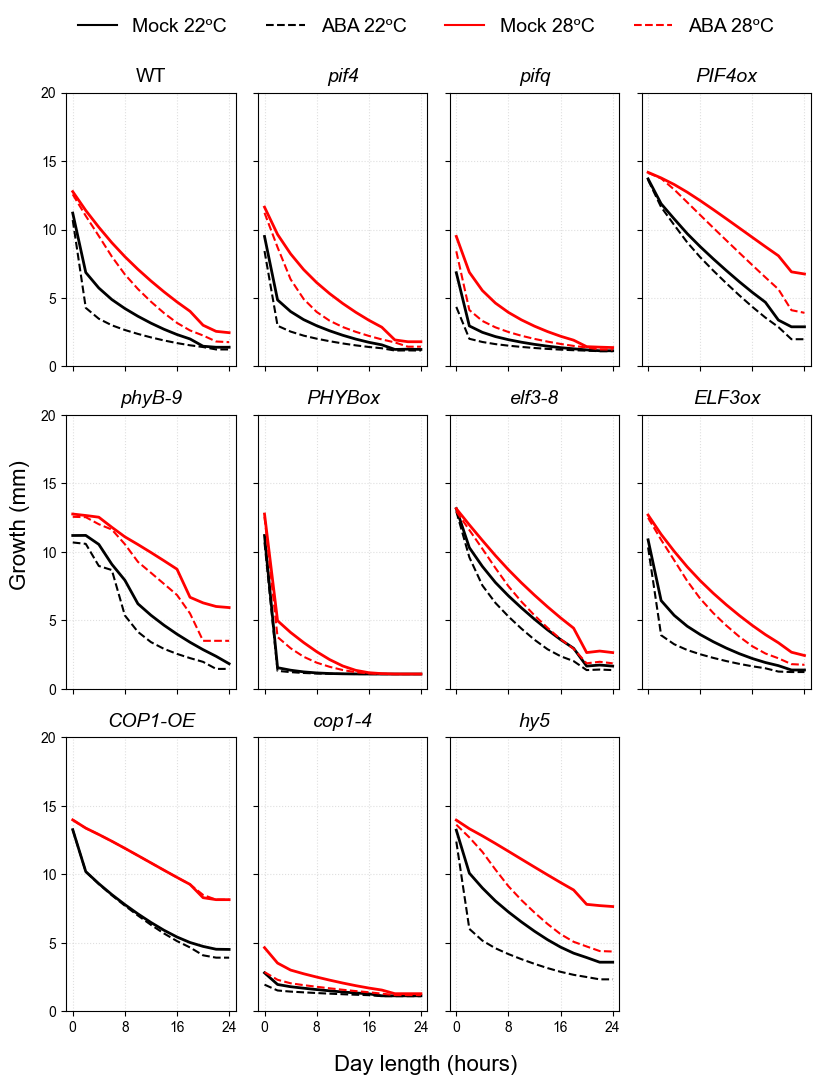

In [156]:
# =========================
#    Prediccion Display
# =========================
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'Liberation Sans'],
    'font.size': 10
})

n_gen = len(genotypes)
cols = 4
rows = (n_gen // cols) + (1 if n_gen % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(8, 3.5 * rows), sharex=True)
axes = axes.flatten()


for i, g_name in enumerate(genotypes.keys()):
    ax = axes[i]
    
    # 22ºC - Black
    ax.plot(daylengths, results[g_name][22][0.0], 'k-', linewidth=2)  # Mock
    ax.plot(daylengths, results[g_name][22][1.0], 'k--', linewidth=1.5) # ABA
    
    # 28ºC - Red
    ax.plot(daylengths, results[g_name][28][0.0], 'r-', linewidth=2)  # Mock
    ax.plot(daylengths, results[g_name][28][1.0], 'r--', linewidth=1.5) # ABA
    
    # Fontstyle for genotypes
    fontstyle_genotype = 'normal' if g_name == "WT" else 'italic'
    ax.set_title(g_name, fontstyle=fontstyle_genotype, fontsize=14, pad=8) # fontweight='bold',
    
    # Axis configuration
    ax.set_xlim(-1, 25); ax.set_xticks([0, 8, 16, 24]) 
    ax.set_ylim(0, 20); ax.set_yticks([0, 5, 10, 15, 20]); 
    ax.grid(True, linestyle=':', alpha=0.4)
    
    # Only show numbers on the Y-axis for the first column
    if i % cols != 0: ax.set_yticklabels([])
    # ax.set_ylabel("")
    
    # Only show numbers on the X-axis for the last row
    # if i < (n_gen - rows): ax.set_xticklabels([])
    # ax.set_xlabel("")
    
    # if i % cols == 0: ax.set_ylabel("Growth (mm)")
    # if i >= (n_gen - cols): ax.set_xlabel("Day length (hours)")

# Leyend Upper Center
handles = [
    mlines.Line2D([], [], color='black', linestyle='-',  label='Mock 22ºC'),
    mlines.Line2D([], [], color='black', linestyle='--', label='ABA 22ºC'),
    mlines.Line2D([], [], color='red',   linestyle='-',  label='Mock 28ºC'),
    mlines.Line2D([], [], color='red',   linestyle='--', label='ABA 28ºC')
]

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.0),
           ncol=14, frameon=False, fontsize=14)

# Delete unused subplots
for j in range(i + 1, len(axes)): fig.delaxes(axes[j])

# Axis titles
fig.text(-0.02, 0.5, 'Growth (mm)', va='center', rotation='vertical', fontsize=16) # fontweight='bold'
fig.text(0.5, -0.02, 'Day length (hours)', ha='center', fontsize=16)                         # fontweight='bold'

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 1.3. Predictions on the Nieto Growth Conditions Framework

In [154]:
# =========================
#  GENOTYPES & SIMULATION
# =========================
common_params['gamma_G'] = 1.0

# Genotype dictionary
genotypes = {
    "WT": {},
    "pif4": {"mutP": "pif4"},
    "pifq": {"mutP": "pifq"},
    "PIF4ox": {"mutP": "PIF4ox-Nieto"},
    "phyB-9": {"mutB": "phyB-9"},
    "PHYBox": {"mutB": "PHYBox"},
    "elf3-8": {"mutE": "elf3-8"},
    "ELF3ox": {"mutE": "ELF3ox"},
    "COP1-OE": {"mutC": "COP1-OE"},
    "cop1-4": {"mutC": "cop1-4"},
    "hy5": {"mutH": "hy5"}
}

daylengths = np.arange(0, 25, 2)
temperatures = [22, 28]
days_sim = 5

results = {g: {t: {0.0: [], 1.0: []} for t in temperatures} for g in genotypes}

print("Calculating growth trajectories...")
for g_name, kwargs in genotypes.items():
    for t in temperatures:
        for aba_val in [0.0, 1.0]:
            for dl in daylengths:
                val = simulate_final_growth(t, dl, days_sim, aba_val, **kwargs)
                results[g_name][t][aba_val].append(val)
    print(f"{g_name} complete.")

Calculating growth trajectories...
WT complete.
pif4 complete.
pifq complete.
PIF4ox complete.
phyB-9 complete.
PHYBox complete.
elf3-8 complete.
ELF3ox complete.
COP1-OE complete.
cop1-4 complete.
hy5 complete.


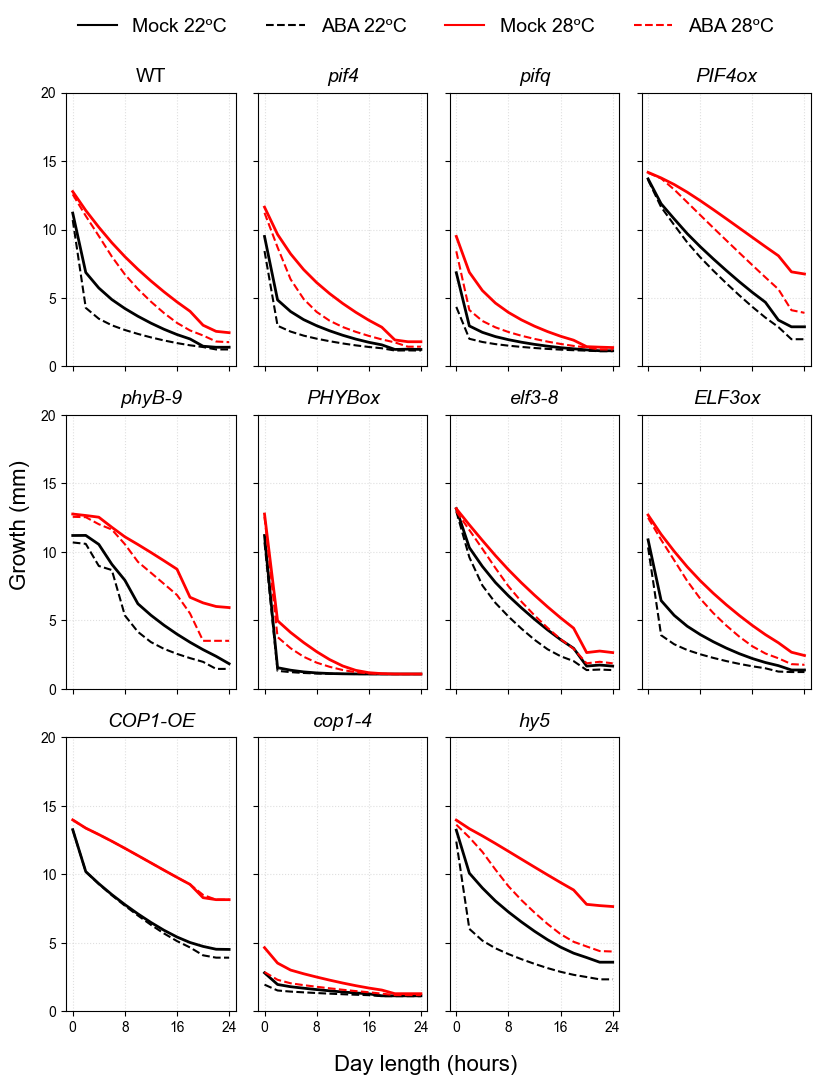

In [157]:
# =========================
#    Prediccion Display
# =========================
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'Liberation Sans'],
    'font.size': 10
})

n_gen = len(genotypes)
cols = 4
rows = (n_gen // cols) + (1 if n_gen % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(8, 3.5 * rows), sharex=True)
axes = axes.flatten()


for i, g_name in enumerate(genotypes.keys()):
    ax = axes[i]
    
    # 22ºC - Black
    ax.plot(daylengths, results[g_name][22][0.0], 'k-', linewidth=2)  # Mock
    ax.plot(daylengths, results[g_name][22][1.0], 'k--', linewidth=1.5) # ABA
    
    # 28ºC - Red
    ax.plot(daylengths, results[g_name][28][0.0], 'r-', linewidth=2)  # Mock
    ax.plot(daylengths, results[g_name][28][1.0], 'r--', linewidth=1.5) # ABA
    
    # Fontstyle for genotypes
    fontstyle_genotype = 'normal' if g_name == "WT" else 'italic'
    ax.set_title(g_name, fontstyle=fontstyle_genotype, fontsize=14, pad=8) # fontweight='bold',
    
    # Axis configuration
    ax.set_xlim(-1, 25); ax.set_xticks([0, 8, 16, 24]) 
    ax.set_ylim(0, 20); ax.set_yticks([0, 5, 10, 15, 20]); 
    ax.grid(True, linestyle=':', alpha=0.4)
    
    # Only show numbers on the Y-axis for the first column
    if i % cols != 0: ax.set_yticklabels([])
    # ax.set_ylabel("")
    
    # Only show numbers on the X-axis for the last row
    # if i < (n_gen - rows): ax.set_xticklabels([])
    # ax.set_xlabel("")
    
    # if i % cols == 0: ax.set_ylabel("Growth (mm)")
    # if i >= (n_gen - cols): ax.set_xlabel("Day length (hours)")

# Leyend Upper Center
handles = [
    mlines.Line2D([], [], color='black', linestyle='-',  label='Mock 22ºC'),
    mlines.Line2D([], [], color='black', linestyle='--', label='ABA 22ºC'),
    mlines.Line2D([], [], color='red',   linestyle='-',  label='Mock 28ºC'),
    mlines.Line2D([], [], color='red',   linestyle='--', label='ABA 28ºC')
]

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.0),
           ncol=14, frameon=False, fontsize=14)

# Delete unused subplots
for j in range(i + 1, len(axes)): fig.delaxes(axes[j])

# Axis titles
fig.text(-0.02, 0.5, 'Growth (mm)', va='center', rotation='vertical', fontsize=16) # fontweight='bold'
fig.text(0.5, -0.02, 'Day length (hours)', ha='center', fontsize=16)                         # fontweight='bold'

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()